In [40]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 15
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'  

from artap.operators import RandomGenerator, FullFactorGenerator, FullFactorLevelsGenerator, PlackettBurmanGenerator, BoxBehnkenGenerator, LHSGenerator, GSDGenerator, HaltonGenerator

In [41]:
U = 22e3

rho = 1e-5
eps0 = 8.854e-12

a = 0.1
b = 0.2
c = 10.0
cfig = 0.5

N = 15
sampling = "equidistant"
#sampling = "lhs"
#sampling = "halton"
#sampling = "random"

N_pred = 100

xlimits = np.array([[a, c]])

In [42]:
# analytic solution
A = np.array([
    [np.log(a), 1, 0, 0], 
    [0, 0, np.log(c), 1],
    [-np.log(b), -1, np.log(b), 1],
    [-1/b, 0, 1/b, 0]])
B = np.array([U + rho * a**2 / (eps0 * 4), 
              0,               
              - rho * b**2 / (eps0 * 4),
              - rho * b / (eps0 * 2)])

X = np.linalg.solve(A, B)

k11 = X[0]
k12 = X[1]
k21 = X[2]
k22 = X[3]

def phi_fce(r):
    if 0 < r < a:
        voltage = U
        intensity = 0
    elif a <= r < b:
        voltage = - rho / eps0 * r**2 / 4 + k11 * np.log(r) + k12
        intensity = rho / eps0 * r / 2 - k11 / r
    elif b <= r < c:
        voltage = k21 * np.log(r) + k22
        intensity = - k21 / r
    else:
        voltage = 0
        intensity = 0
    
    voltage *= 1e-3
    intensity *= 1e-3
    
    return [voltage, intensity]

In [43]:
# fine division for function plot without DOE
r_fine = np.linspace(a, cfig, 1000)
phi_fine = []
e_fine = []
for x in r_fine:    
    [voltage, intensity] = phi_fce(x)
    phi_fine.append(voltage)
    e_fine.append(intensity)

In [44]:
parameters = [{'name': 'x_1', 'initial_value': b, 'bounds': [a, cfig]}]

def doe_equidistant():
    r = np.linspace(a, cfig, N)
    phi = []
    e = []
    for rr in r:
        [voltage, intensity] = phi_fce(rr)
        phi.append(voltage)
        e.append(intensity)
        
    return [r, phi, e, "Equidistant"]

def doe_random():
    import random 
    
    r = []
    for i in range(N):
        r.append(random.uniform(a, cfig))
    r = sorted(r)
    
    phi = []
    e = []
    for rr in r:
        [voltage, intensity] = phi_fce(rr)
        phi.append(voltage)
        e.append(intensity)
        
    return [r, phi, e, "Random"]


def doe_lhs():
    gen = LHSGenerator(parameters=parameters)
    gen.init(number=N)
    individuals = gen.generate()

    r = []
    phi = []
    e = []
    for individual in individuals:
        rr = individual.vector[0]
        r.append(rr)
        [voltage, intensity] = phi_fce(rr)
        phi.append(voltage)
        e.append(intensity)
        
    return [r, phi, e, "LHS"]

def doe_halton():
    gen = HaltonGenerator(parameters=parameters)
    gen.init(number=N)
    individuals = gen.generate()

    r = []
    phi = []
    e = []
    for individual in individuals:
        rr = individual.vector[0]
        r.append(rr)
        [voltage, intensity] = phi_fce(rr)
        phi.append(voltage)
        e.append(intensity)
        
    return [r, phi, e, "Halton"]

if sampling == "equidistant":
    [r, phi, e, desc_sampling] = doe_equidistant()
elif sampling == "lhs":
    [r, phi, e, desc_sampling] = doe_lhs()
elif sampling == "halton":    
    [r, phi, e, desc_sampling] = doe_halton()
elif sampling == "random":
    [r, phi, e, desc_sampling] = doe_random()

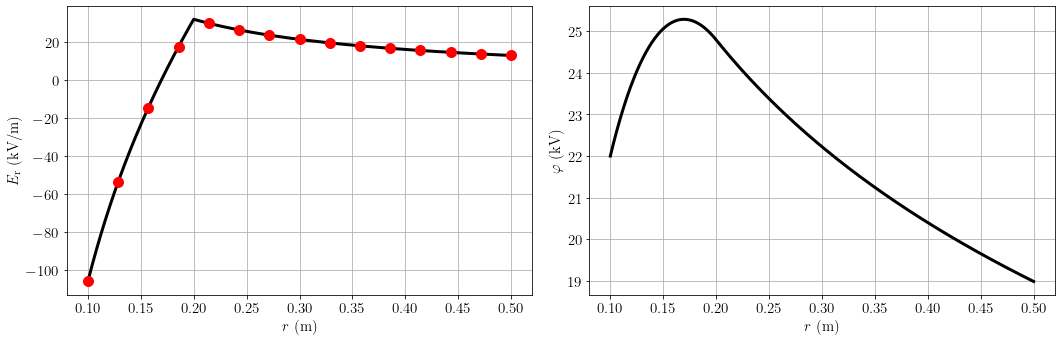

In [45]:
plt.subplot(1,2,1)
plt.plot(r_fine, e_fine, 'k', linewidth=3)
plt.plot(r, e, 'or', markersize=10)
plt.grid(True)
plt.xlabel('$r$ (m)')
plt.ylabel('$E_{\mathrm{r}}$ (kV/m)')
plt.grid(True)       

plt.subplot(1,2,2)
plt.plot(r_fine, phi_fine, 'k', linewidth=3)
plt.grid(True)
plt.xlabel('$r$ (m)')
plt.ylabel('$\\varphi$ (kV)')
plt.grid(True)       

plt.tight_layout()
plt.show()

In [46]:
# prediction
r_pred = np.linspace(a, cfig, N_pred)
phi_pred = []
e_pred = []
for x in r_pred:    
    [voltage, intensity] = phi_fce(x)
    phi_pred.append([voltage])
    e_pred.append([intensity])

In [47]:
# SMT prediction
import smt
from smt.surrogate_models import RMTB, LS, KRG, QP, MGP
print(smt.__version__)

def pred_rmtb():
    rmtb = RMTB(
        num_ctrl_pts=100,
        xlimits=xlimits,
        nonlinear_maxiter=20,
        solver_tolerance=1e-16,
        energy_weight=1e-14,
        regularization_weight=0.0,
    )
    # rmtb.set_training_values(np.array(r), np.array(phi))
    rmtb.set_training_values(np.array(r), np.array(e))
    rmtb.train()

    return rmtb.predict_values(r_pred)

def pred_ls():
    ls = LS()
    #ls.set_training_values(np.array(r), np.array(phi))
    ls.set_training_values(np.array(r), np.array(e))
    ls.train()

    return ls.predict_values(r_pred)    

def pred_qp():
    qp = QP()

    #qp.set_training_values(np.array(r), np.array(phi))
    qp.set_training_values(np.array(r), np.array(e))
    qp.train()

    return qp.predict_values(r_pred)
    
def pred_krg():
    krg = KRG(theta0=[1e-2])
    #krg.set_training_values(np.array(r), np.array(phi))
    krg.set_training_values(np.array(r), np.array(e))
    krg.train()

    return krg.predict_values(r_pred)        

# def pred_mgp():    
#     mgp = MGP(theta0=[1e-2], n_comp=1)
#     mgp.set_training_values(np.array(r), np.array(phi))
#     mgp.train()

#     phi_pred_mgp = mgp.predict_values(r_pred)
#     return phi_pred_mgp

0.7.0


In [48]:
rmtb = pred_rmtb()
ls = pred_ls()
qp = pred_qp()
krg = pred_krg()

___________________________________________________________________________
   
                                   RMTB
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 15
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Pre-computing matrices ...
         Computing dof2coeff ...
         Computing dof2coeff - done. Time (sec):  0.0000057
         Initializing Hessian ...
         Initializing Hessian - done. Time (sec):  0.0022216
         Computing energy terms ...
         Computing energy terms - done. Time (sec):  0.0022922
         Computing approximation terms ...
         Computing approximation terms - done. Time (sec):  0.0007772
      Pre-computing matrices - done. Time (sec):  0.0058050
      Solving for degrees of freedom ...
         Solving initial startup problem (n=100) ...
            Solving for output 0 ...
       

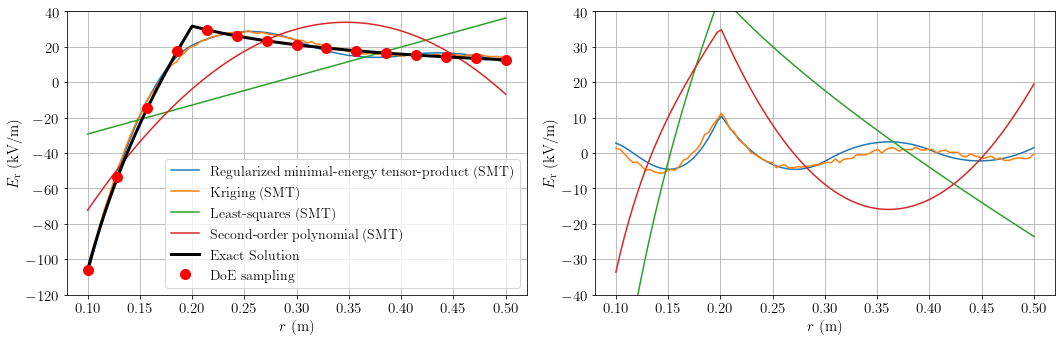

In [50]:
plt.subplot(1,2,1)
plt.plot(r_pred, rmtb, label='Regularized minimal-energy tensor-product (SMT)')
plt.plot(r_pred, krg, label='Kriging (SMT)')
plt.plot(r_pred, ls, label='Least-squares (SMT)')
plt.plot(r_pred, qp, label='Second-order polynomial (SMT)')
plt.plot(r_fine, e_fine, 'k', linewidth=3, label='Exact Solution')
plt.plot(r, e, 'or', markersize=10, label="DoE sampling")
plt.ylim([-120, 40])
plt.grid(True)
plt.xlabel('$r$ (m)')
plt.ylabel('$E_{\mathrm{r}}$ (kV/m)')
plt.grid(True)       
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(r_pred, e_pred-rmtb, label='Regularized minimal-energy tensor-product (SMT)')
plt.plot(r_pred, e_pred-krg, label='Kriging (SMT)')
plt.plot(r_pred, e_pred-ls, label='Least-squares (SMT)')
plt.plot(r_pred, e_pred-qp, label='Second-order polynomial (SMT)')
plt.ylim([-40, 40])
plt.grid(True)
plt.xlabel('$r$ (m)')
plt.ylabel('$E_{\mathrm{r}}$ (kV/m)')
plt.grid(True)       
plt.tight_layout()

plt.show()

In [52]:
# quadratic deviation of the solution
diff_rmtb = 0
diff_krg = 0
diff_ls = 0
diff_qp = 0
for i in range(len(r_pred)):
    diff_rmtb += ((e_pred[i]-rmtb[i]))**2
    diff_krg += ((e_pred[i]-krg[i]))**2
    diff_ls += ((e_pred[i]-ls[i]))**2
    diff_qp += ((e_pred[i]-qp[i]))**2
diff_rmtb /= len(r_pred)
diff_rmtb_abs = np.sqrt(diff_rmtb)[0]
diff_krg /= len(r_pred)
diff_krg_abs = np.sqrt(diff_krg)[0]
diff_ls /= len(r_pred)
diff_ls_abs = np.sqrt(diff_ls)[0]
diff_qp /= len(r_pred)
diff_qp_abs = np.sqrt(diff_qp)[0]

print(diff_rmtb, diff_rmtb_abs)
print(diff_krg, diff_krg_abs)
print(diff_ls, diff_ls_abs)
print(diff_qp, diff_qp_abs)

[10.29069859] 3.207911874224657
[10.79062864] 3.2849092285950343
[653.61091472] 25.565815354118957
[247.89328439] 15.744627159418014


In [53]:
# scikit
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, ExpSineSquared
# from sklearn.gaussian_process.kernels RBF, Matern, DotProduct, WhiteKernel, ConstantKernel
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, WhiteKernel, ConstantKernel, RationalQuadratic, ExpSineSquared

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

def pred_random_forest():
    # Random Forest
    regressor = RandomForestRegressor(n_estimators=50)
    # regressor.fit(np.array(r).reshape(-1, 1), np.array(phi).reshape(-1, 1))

    #     parameters = {
    #                 'bootstrap': [True],
    #                 'max_depth': [80, 90, 100, 110],
    #                 'max_features': [1],
    #                 'min_samples_leaf': [3, 4, 5],
    #                 'min_samples_split': [8, 10, 12],
    #                 'n_estimators': [10, 50, 100, 500]}

    #     regressor = GridSearchCV(regressor, parameters, n_jobs=-1, verbose=True)
    
    # regressor.fit(np.array(r).reshape(-1, 1), np.array(phi))    
    regressor.fit(np.array(r).reshape(-1, 1), np.array(e))    
    return regressor.predict(np.array(r_pred).reshape(-1, 1))

def pred_mlp():
    # Multi-layer Perceptron
    regressor = MLPRegressor(hidden_layer_sizes=(6), max_iter=500, activation='relu', solver='lbfgs')
    
    #     parameters = {
    #                 'solver': ['lbfgs'],
    #                 'max_iter': [1000, 1500, 2000],
    #                 'alpha': [1.e-01, 1.e-05, 1.e-09],
    #                 "hidden_layer_sizes": [(3), (10), (20), (50)],
    #                 'random_state': [0, 2, 4, 5, 8, 9],
    #                 "activation": ['logistic', 'relu']}

    #     regressor = GridSearchCV(regressor, parameters, n_jobs=-1, verbose=True)
    
    # regressor.fit(np.array(r).reshape(-1, 1), np.array(phi))    
    regressor.fit(np.array(r).reshape(-1, 1), np.array(e))    
    return regressor.predict(np.array(r_pred).reshape(-1, 1))

def pred_gp():
    # Gaussian Process
    regressor = GaussianProcessRegressor(kernel=RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    
    #     ker_rbf1 = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
    #     ker_rbf2 = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds=(1e-1, 10.0))
    #     ker_rq = ConstantKernel(1.0, constant_value_bounds="fixed") * RationalQuadratic(alpha=0.1, length_scale=1)
    #     ker_expsine = ConstantKernel(1.0, constant_value_bounds="fixed") * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))

    #     kernel_list = [ker_rbf1, ker_rbf2, ker_rq, ker_expsine]

    #     parameters = {
    #                 "kernel": kernel_list,
    #                 "alpha": [1e-12, 1e-8, 1e-4, 1e-1, 1e1],
    #                 # "alpha": [1e-10],
    #                 "optimizer": ["fmin_l_bfgs_b"],
    #                 "n_restarts_optimizer": [1, 3, 10, 20],
    #                 # "n_restarts_optimizer": [9],
    #                 "normalize_y": [False],
    #                 "copy_X_train": [True],
    #                 "random_state": [0]}


    #     regressor = GridSearchCV(regressor, parameters, n_jobs=-1, verbose=True)
    
    # regressor.fit(np.array(r).reshape(-1, 1), np.array(phi))    
    regressor.fit(np.array(r).reshape(-1, 1), np.array(e))    
    return regressor.predict(np.array(r_pred).reshape(-1, 1))

In [54]:
random_forest = pred_random_forest()
mlp = pred_mlp()
gp = pred_gp()

In [55]:
# quadratic deviation of the solution
diff_random_forest = 0
diff_mlp = 0
diff_gp = 0
for i in range(len(r_pred)):
    diff_random_forest += ((e_pred[i]-random_forest[i]))**2
    diff_mlp += ((e_pred[i]-mlp[i]))**2
    diff_gp += ((e_pred[i]-gp[i]))**2
diff_random_forest /= len(r_pred)
diff_random_forest_abs = np.sqrt(diff_random_forest)[0]
diff_mlp /= len(r_pred)
diff_mlp_abs = np.sqrt(diff_mlp)[0] 
diff_gp /= len(r_pred)
diff_gp_abs = np.sqrt(diff_gp)[0]


print(diff_random_forest, diff_random_forest_abs)
print(diff_mlp, diff_mlp_abs)
print(diff_gp, diff_gp_abs)

[37.01795148] 6.084237953876683
[653.6103383] 25.565804080908975
[0.76028024] 0.8719405033703927


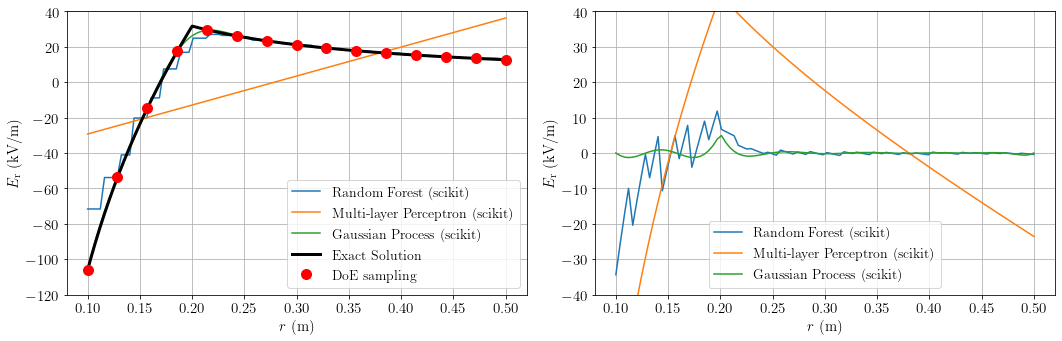

In [56]:
plt.subplot(1,2,1)
plt.plot(r_pred, random_forest, label='Random Forest (scikit)')
plt.plot(r_pred, mlp, label='Multi-layer Perceptron (scikit)')
plt.plot(r_pred, gp, label='Gaussian Process (scikit)')
plt.plot(r_fine, e_fine, 'k', linewidth=3, label='Exact Solution')
plt.plot(r, e, 'or', markersize=10, label="DoE sampling")
plt.ylim([-120, 40])
plt.grid(True)
plt.xlabel('$r$ (m)')
plt.ylabel('$E_{\mathrm{r}}$ (kV/m)')
plt.grid(True)       
plt.legend()    
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(r_pred, e_pred-np.array([[x] for x in random_forest]), label='Random Forest (scikit)')
plt.plot(r_pred, e_pred-np.array([[x] for x in mlp]), label='Multi-layer Perceptron (scikit)')
plt.plot(r_pred, e_pred-np.array([[x] for x in gp]), label='Gaussian Process (scikit)')
plt.ylim([-40, 40])
plt.grid(True)
plt.xlabel('$r$ (m)')
plt.ylabel('$E_{\mathrm{r}}$ (kV/m)')
plt.grid(True)       
plt.legend()    
plt.tight_layout()
plt.show()

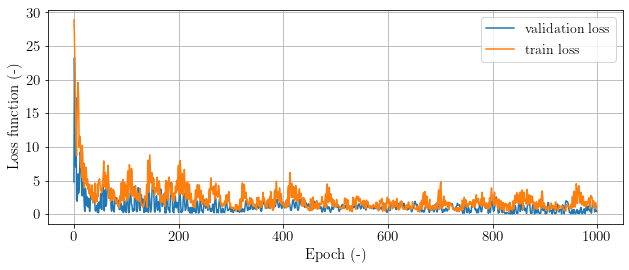

In [57]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing

normalizer = preprocessing.Normalization(input_shape=[1,])
normalizer.adapt(np.array(r))

def build_model():
    model = keras.Sequential([
      normalizer,
      keras.layers.Dense(128, activation='relu'),      
      keras.layers.Dense(128, activation='relu'),      
      keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
                loss='mean_absolute_error')
    return model

epochs = 1000
model_tensorflow = build_model()

# train - fixed
history = model_tensorflow.fit(np.array(r), np.array(e), 
                    epochs=epochs, validation_split=0.1, verbose=0)

def plot_loss(history):
    plt.figure(figsize=(9, 4))
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.plot(history.history['loss'], label='train loss')
    # plt.ylim([0, 10])
    plt.xlabel('Epoch (-)')
    plt.ylabel('Loss function (-)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()    

plot_loss(history)

tensorflow = model_tensorflow.predict(np.array(r_pred))

In [58]:
# quadratic deviation of the solution
diff_tensorflow = 0
for i in range(len(r_pred)):
    diff_tensorflow += ((e_pred[i]-tensorflow[i]))**2
diff_tensorflow /= len(r_pred)
diff_tensorflow_abs = np.sqrt(diff_tensorflow)[0] 


print(diff_tensorflow, diff_tensorflow_abs)

[3.08949408] 1.757695672112229


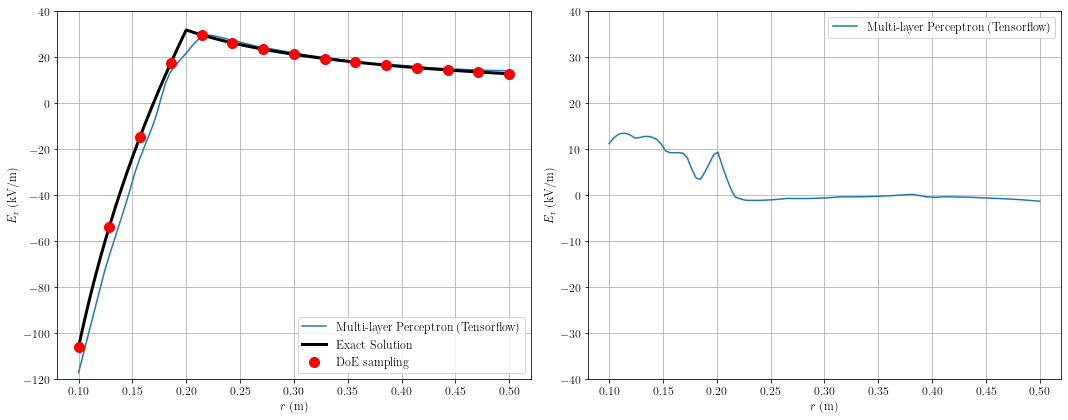

In [18]:
plt.subplot(1,2,1)
plt.plot(r_pred, tensorflow, label='Multi-layer Perceptron (Tensorflow)')
plt.plot(r_fine, e_fine, 'k', linewidth=3, label='Exact Solution')
plt.plot(r, e, 'or', markersize=10, label="DoE sampling")
plt.ylim([-120, 40])
plt.grid(True)
plt.xlabel('$r$ (m)')
plt.ylabel('$E_{\mathrm{r}}$ (kV/m)')
plt.grid(True)       
plt.legend()    
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(r_pred, e_pred-tensorflow, label='Multi-layer Perceptron (Tensorflow)')
plt.ylim([-40, 40])
plt.grid(True)
plt.xlabel('$r$ (m)')
plt.ylabel('$E_{\mathrm{r}}$ (kV/m)')
plt.grid(True)       
plt.legend()    
plt.tight_layout()

#plt.savefig('korona_potencial_tensorflow.pdf')
plt.show()

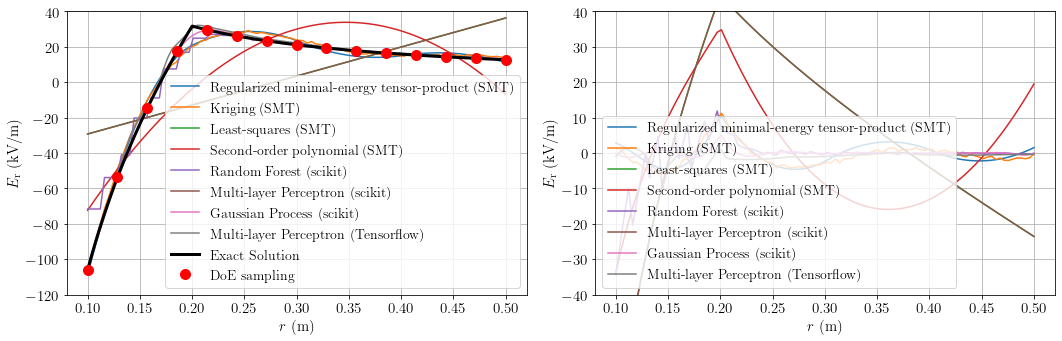

In [59]:
# all figures
plt.subplot(1,2,1)
plt.plot(r_pred, rmtb, label='Regularized minimal-energy tensor-product (SMT)')
plt.plot(r_pred, krg, label='Kriging (SMT)')
plt.plot(r_pred, ls, label='Least-squares (SMT)')
plt.plot(r_pred, qp, label='Second-order polynomial (SMT)')
plt.plot(r_pred, random_forest, label='Random Forest (scikit)')
plt.plot(r_pred, mlp, label='Multi-layer Perceptron (scikit)')
plt.plot(r_pred, gp, label='Gaussian Process (scikit)')
plt.plot(r_pred, tensorflow, label='Multi-layer Perceptron (Tensorflow)')
plt.plot(r_fine, e_fine, 'k', linewidth=3, label='Exact Solution')
plt.plot(r, e, 'or', markersize=10, label="DoE sampling")
plt.ylim([-120, 40])
plt.grid(True)
plt.xlabel('$r$ (m)')
plt.ylabel('$E_{\mathrm{r}}$ (kV/m)')
plt.grid(True)       
plt.legend()    
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(r_pred, e_pred-rmtb, label='Regularized minimal-energy tensor-product (SMT)')
plt.plot(r_pred, e_pred-krg, label='Kriging (SMT)')
plt.plot(r_pred, e_pred-ls, label='Least-squares (SMT)')
plt.plot(r_pred, e_pred-qp, label='Second-order polynomial (SMT)')
plt.plot(r_pred, e_pred-np.array([[x] for x in random_forest]), label='Random Forest (scikit)')
plt.plot(r_pred, e_pred-np.array([[x] for x in mlp]), label='Multi-layer Perceptron (scikit)')
plt.plot(r_pred, e_pred-np.array([[x] for x in gp]), label='Gaussian Process (scikit)')
plt.plot(r_pred, e_pred-tensorflow, label='Multi-layer Perceptron (Tensorflow)')
plt.ylim([-40, 40])
plt.grid(True)
plt.xlabel('$r$ (m)')
plt.ylabel('$E_{\mathrm{r}}$ (kV/m)')
plt.grid(True)       
plt.legend()    
plt.tight_layout()

plt.show()

In [60]:
print("N = {}".format(N))
print("Sampling = {}".format(desc_sampling))
print()

print("Regularized minimal-energy tensor-product (SMT){:>10.2f}".format(diff_rmtb_abs))
print("Kriging (SMT)                                  {:>10.2f}".format(diff_krg_abs))
print("Least-squares (SMT)                            {:>10.2f}".format(diff_ls_abs))
print("Second-order polynomial (SMT)                  {:>10.2f}".format(diff_qp_abs))
print("Random Forest (Scikit)                         {:>10.2f}".format(diff_random_forest_abs))
print("Multi-layer Perceptron (Scikit)                {:>10.2f}".format(diff_mlp_abs))
print("Gaussian Process (Scikit)                      {:>10.2f}".format(diff_gp_abs))
print("Multi-layer Perceptron (Tensorflow)            {:>10.2f}".format(diff_tensorflow_abs))

N = 15
Sampling = Equidistant

Regularized minimal-energy tensor-product (SMT)      3.21
Kriging (SMT)                                        3.28
Least-squares (SMT)                                 25.57
Second-order polynomial (SMT)                       15.74
Random Forest (Scikit)                               6.08
Multi-layer Perceptron (Scikit)                     25.57
Gaussian Process (Scikit)                            0.87
Multi-layer Perceptron (Tensorflow)                  1.76


In [61]:
# optimization
from artap.problem import Problem
from artap.results import Results
from artap.algorithm_nlopt import NLopt
from artap.algorithm_nlopt import LN_BOBYQA, GN_MLSL, GN_CRS2_LM, GN_ISRES
from artap.algorithm_genetic import NSGAII
    
regressor = GaussianProcessRegressor(kernel=RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
regressor.fit(np.array(r).reshape(-1, 1), np.array(e))     

GaussianProcessRegressor(kernel=RBF(length_scale=1))

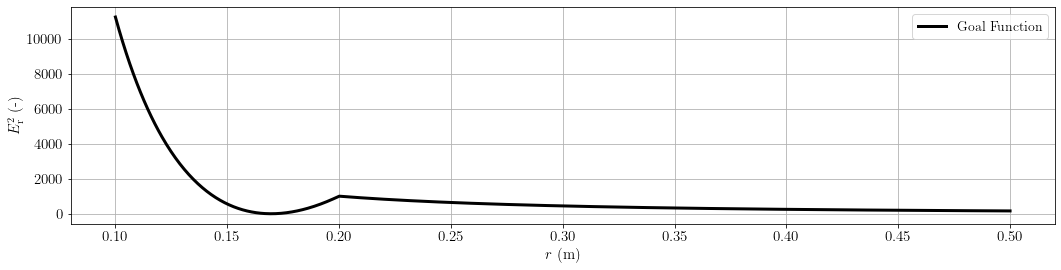

In [69]:
# goal function
e_fine_goal = []
for e in e_fine:
    e_fine_goal.append(e**2)    

plt.rcParams['figure.figsize'] = (15, 4)
plt.plot(r_fine, e_fine_goal, 'k', linewidth=3, label='Goal Function')
plt.grid(True)
plt.xlabel('$r$ (m)')
plt.ylabel('$E_{\mathrm{r}}^2$ (-)')
#plt.xlim([0.15, 0.18])
#plt.ylim([-15, 5])
plt.legend()

plt.tight_layout()

plt.savefig('korona_optimalizace_cilova_funkce.pdf')
plt.show()

In [70]:
class SurrogateStaticProblem(Problem):
    def set(self):
        self.parameters = [{'name': 'r', 'initial_value': a, 'bounds': [a, cfig]}]
        self.costs = [{'name': 'F'}]

    def evaluate(self, individual):
        value = regressor.predict(np.array([individual.vector]))[0]
        # cilova fce je kvadraticka odchylka od nulove intenzity
        value = [float(value)**2]
        # value = [np.fabs(float(value))]
        # value = [float(individual.vector[0])**2]
        # print(individual.vector, value)
        return value
            
surrogate_problem = SurrogateStaticProblem()

# surrogate_algorithm = NLopt(surrogate_problem)
# surrogate_algorithm.options['verbose_level'] = 1
# surrogate_algorithm.options['algorithm'] = GN_ISRES
# surrogate_algorithm.options['xtol_abs'] = 1e-6
# surrogate_algorithm.options['xtol_rel'] = 1e-3
# surrogate_algorithm.options['ftol_rel'] = 1e-3
# surrogate_algorithm.options['ftol_abs'] = 1e-6
# surrogate_algorithm.options['n_iterations'] = 1000
# surrogate_algorithm.run()

surrogate_algorithm = NSGAII(surrogate_problem)
surrogate_algorithm.options['max_population_number'] = 1000
surrogate_algorithm.options['max_population_size'] = 10
surrogate_algorithm.options['max_processes'] = 1
surrogate_algorithm.run()

surrogate_index = []
surrogate_parameter = []
surrogate_cost = []
populations = surrogate_problem.populations().values()
for individuals in populations:
    for individual in individuals:
        surrogate_index.append(len(surrogate_index)+1)
        surrogate_parameter.append(individual.vector[0])
        surrogate_cost.append(individual.costs[0])

surrogate_results = Results(surrogate_problem)
surrogate_optimum = surrogate_results.find_optimum('F') 

print(surrogate_optimum)

2020-12-25 15:08:39,094 (INFO): SurrogateStaticProblem-090092 - run (146) - NSGA_II: 1000/10000
2020-12-25 15:08:42,197 (INFO): SurrogateStaticProblem-090092 - run (173) - NSGA_II: elapsed time: 3.1026124954223633 s


vector: [0.168695054484612]; costs:[2.651947261120125e-05]; features:['start_time': 1608905321.866244, 'finish_time': 1608905321.8663912, 'feasible': 0.0, 'precision': 7, 'dominate': [82696, 87989, 96641, 87421, 95621, 88913, 86021, 96525, 88720, 96341, 98061, 98064, 98065, 98068, 98069, 98072, 98073, 98076, 98077], 'crowding_distance': inf, 'domination_counter': 0, 'front_number': 1, ]


In [74]:
class ExactStaticProblem(Problem):
    def set(self):
        self.parameters = [{'name': 'r', 'initial_value': a, 'bounds': [a, cfig]}]
        self.costs = [{'name': 'F'}]

    def evaluate(self, individual):
        [voltage, intensity] = phi_fce(individual.vector[0])
        # cilova fce je kvadraticka odchylka od nulove intenzity
        value = [intensity**2]
        # value = [np.fabs(intensity)]
        # value = [float(individual.vector[0])**2]
        # print(individual.vector, value)
        return value
            
exact_problem = ExactStaticProblem()

# exact_algorithm = NLopt(exact_problem)
# exact_algorithm.options['verbose_level'] = 1
# exact_algorithm.options['algorithm'] = GN_ISRES
# exact_algorithm.options['xtol_abs'] = 1e-6
# exact_algorithm.options['xtol_rel'] = 1e-3
# exact_algorithm.options['ftol_rel'] = 1e-3
# exact_algorithm.options['ftol_abs'] = 1e-6
# exact_algorithm.options['n_iterations'] = 1000
# exact_algorithm.run()

exact_algorithm = NSGAII(exact_problem)
exact_algorithm.options['max_population_number'] = 1000
exact_algorithm.options['max_population_size'] = 10
exact_algorithm.options['max_processes'] = 1
exact_algorithm.run()

exact_index = []
exact_parameter = []
exact_cost = []
populations = exact_problem.populations().values()
for individuals in populations:
    for individual in individuals:
        exact_index.append(len(exact_index)+1)
        exact_parameter.append(individual.vector[0])
        exact_cost.append(individual.costs[0])

exact_results = Results(exact_problem)
exact_optimum = exact_results.find_optimum('F') 

print(exact_optimum)

2020-12-25 15:08:55,912 (INFO): ExactStaticProblem-909492 - run (146) - NSGA_II: 1000/10000
2020-12-25 15:08:57,933 (INFO): ExactStaticProblem-909492 - run (173) - NSGA_II: elapsed time: 2.0210139751434326 s


vector: [0.1696329610208441]; costs:[3.32412375543025e-05]; features:['start_time': 1608905337.1548657, 'finish_time': 1608905337.1548774, 'feasible': 0.0, 'precision': 7, 'dominate': [129377, 121736, 128836, 129485, 129281, 122901, 122713, 130076, 126124, 128276, 131544, 131545, 131548, 131549, 131552, 131553, 131556, 131560, 131561], 'crowding_distance': inf, 'domination_counter': 0, 'front_number': 1, ]


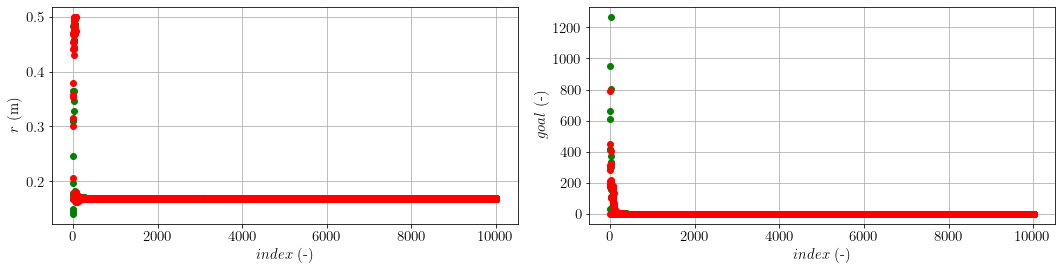

In [75]:
plt.subplot(1,2,1)
plt.plot(exact_index, exact_parameter, 'og')
plt.plot(surrogate_index, surrogate_parameter, 'or')
plt.grid(True)
plt.xlabel('$index$ (-)')
plt.ylabel('$r$ (m)')
plt.grid(True)       
# plt.legend()    
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(exact_index, exact_cost, 'og')
plt.plot(surrogate_index, surrogate_cost, 'or')
plt.grid(True)
plt.xlabel('$index$ (-)')
plt.ylabel('$goal$ (-)')
plt.grid(True)       

plt.tight_layout()
plt.show()

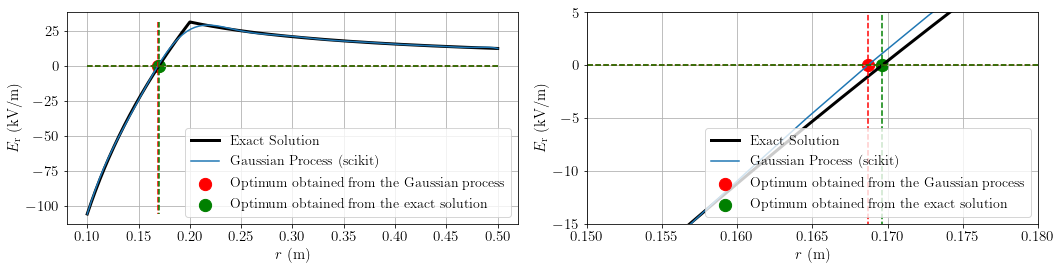

In [76]:
plt.subplot(1,2,1)
plt.plot(r_fine, e_fine, 'k', linewidth=3, label='Exact Solution')
plt.plot(r_pred, gp, label='Gaussian Process (scikit)')
plt.scatter(surrogate_optimum.vector[0], surrogate_optimum.costs[0], c='r', s=150, label='Optimum obtained from the Gaussian process')
plt.plot([surrogate_optimum.vector[0], surrogate_optimum.vector[0]], [max(e_fine), min(e_fine)], 'r--')
plt.plot([max(r_pred), min(r_pred)], [surrogate_optimum.costs[0], surrogate_optimum.costs[0]], 'r--')
plt.scatter(exact_optimum.vector[0], exact_optimum.costs[0], c='g', s=150, label='Optimum obtained from the exact solution')
plt.plot([exact_optimum.vector[0], exact_optimum.vector[0]], [max(e_fine), min(e_fine)], 'g--')
plt.plot([max(r_pred), min(r_pred)], [exact_optimum.costs[0], exact_optimum.costs[0]], 'g--')
plt.grid(True)
plt.xlabel('$r$ (m)')
plt.ylabel('$E_{\mathrm{r}}$ (kV/m)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(r_fine, e_fine, 'k', linewidth=3, label='Exact Solution')
plt.plot(r_pred, gp, label='Gaussian Process (scikit)')
plt.scatter(surrogate_optimum.vector[0], surrogate_optimum.costs[0], c='r', s=150, label='Optimum obtained from the Gaussian process')
plt.plot([surrogate_optimum.vector[0], surrogate_optimum.vector[0]], [max(e_fine), min(e_fine)], 'r--')
plt.plot([max(r_pred), min(r_pred)], [surrogate_optimum.costs[0], surrogate_optimum.costs[0]], 'r--')
plt.scatter(exact_optimum.vector[0], exact_optimum.costs[0], c='g', s=150, label='Optimum obtained from the exact solution')
plt.plot([exact_optimum.vector[0], exact_optimum.vector[0]], [max(e_fine), min(e_fine)], 'g--')
plt.plot([max(r_pred), min(r_pred)], [exact_optimum.costs[0], exact_optimum.costs[0]], 'g--')
plt.grid(True)
plt.xlabel('$r$ (m)')
plt.ylabel('$E_{\mathrm{r}}$ (kV/m)')
plt.xlim([0.15, 0.18])
plt.ylim([-15, 5])
plt.legend()

plt.tight_layout()
plt.show()